# Investigating vertical convcetive transport using a Koopman-VAE framework

## Overview

This notebook outlines the full analysis workflow, including:


1. `Load Simulation Data & Visualize Isentropic Mass Flux`
    - Loading a split of the simulation dataset.
    - Plotting the isentropic mass flux at a selected timestep (using the summed mass flux field).

2.  `Load Preprocessed Training Inputs & Inspect VAE Reconstructions`
    - Loading the processed inputs used to train the model (see data_process.py in KoopmanIsentropicVAE for details):
      - rho_w_sum is flattened.
      - Only pixels activated in the full run are retained.
      - The mean is removed.
      - A Gaussian filter with σ = 1 is applied.
      - A logarithmic transform y = log(1 + x) is used to make pixel distributions closer to Gaussian.
      - The mean image and valid_indices are saved for reconstruction.
    - Loading the trained model (weights stored in .pt format).
    - Inspecting reconstructions for random samples.

3.  `PCA Structure of the Latent Space`
    - Performing PCA in the latent space and visualizing it with point density.
    - Displaying the PCA plane colored by various physical indices (organization, mean LWNTA, precipitation extremes, condensation-rate extremes).

4.  `Koopman Operator: Eigenvalues, Modes, and Reconstructions`
    - Computing the Koopman operator in the latent space (removing the residual latent mean to improve signal).
    - Extracting eigenvectors and eigenvalues of the Koopman operator.
    - Visualizing the reconstruction associated with mode 3.

5.  `Modal Projections, Spectral Analysis, and Latent-Space Velocities`
    - Computing the projection of the latent space onto each mode.
    - Plotting the power spectrum of each modal projection, as well as spectra for organization and condensation rate.
    - Computing the empirical latent-space velocity 

      $
      v_{\text{emp}}(t) = \frac{z(t+n\Delta t) - z(t)}{n\Delta t}.
      $

    - Computing the Koopman-predicted velocity  

      $
      v_{\text{K}}(t) = \frac{\lambda_k^{\,n} - 1}{n\Delta t}\,
      \langle z(t), \Phi_k \rangle\, \Phi_k,
      $

      where oscillatory modes use the normalized eigenvalue  
      $\lambda_k \rightarrow \lambda_k / |\lambda_k|$.


In [2]:
DATA_FOLDER_PATH = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res'

In [3]:
# ===============================================================
# Imports
# ===============================================================

# ---- Standard library ----
import os
import random

# ---- Scientific stack ----
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation

from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

# ---- Models and simulation ----
from KoopmanIsentropicVAE.model import VAE
import pySAMetrics
from pySAMetrics.Simulation_2 import Simulation

# ---- Colormaps ----
import cmocean

# ---- PyTorch ----
import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


# ===============================================================
# Reproducibility
# ===============================================================

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# ===============================================================
# Device selection: MPS → CUDA → CPU
# ===============================================================

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


## 1. `Load Simulation Data & Visualize Isentropic Mass Flux`

In [4]:
# ---------------------------------------------------
# Define paths to raw model outputs (1D/2D/3D NetCDF files)
# ---------------------------------------------------


paths = {
    'path_3d': os.path.join(DATA_FOLDER_PATH, '3D/split_10.nc'),
    'path_2d': os.path.join(DATA_FOLDER_PATH, '2D/split_10.nc'),
    'path_1d': os.path.join(DATA_FOLDER_PATH, '1D/split_10.nc'),
}

# ---------------------------------------------------
# Metadata describing this simulation run
# (parameters expected by the Simulation class)
# ---------------------------------------------------
data_dict = {
    'split_10': {
        'velocity': '8',
        'temperature': '300',
        'bowen_ratio': '1',
        'microphysic': '1',
        'split': '10'
    }
}

# ---------------------------------------------------
# Initialize Simulation object using the 1D/2D/3D files
# ---------------------------------------------------
simu = Simulation(
    data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
    **data_dict['split_10']
)

# ---------------------------------------------------
# Load preprocessed isentropic data (computed once and saved)
# ---------------------------------------------------
simu.load(backup_folder_path=f"{DATA_FOLDER_PATH}/saved_simu_split_10/")

# Show available isentropic fields
simu.dataset_isentropic


<xarray.Dataset> Size: 28MB
Dimensions:     (time: 541, z: 64, fmse: 50)
Dimensions without coordinates: time, z, fmse
Data variables:
    RHO_W_sum   (time, z, fmse) float64 14MB ...
    RHO_W_mean  (time, z, fmse) float64 14MB ...

(0.0, 15.0)

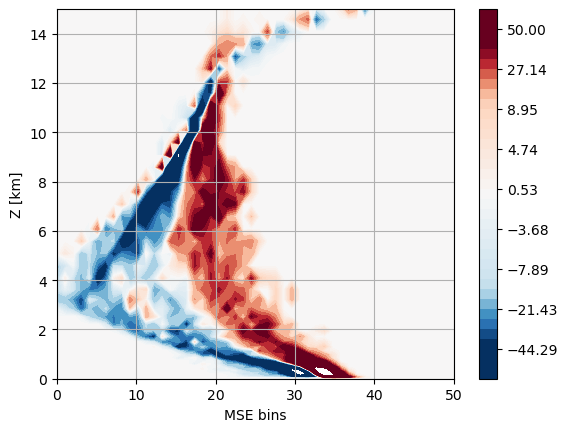

In [26]:
# ---------------------------------------------------
# Extract one isentropic mass-flux field and axes
# ---------------------------------------------------
rho_w_t = simu.dataset_isentropic.RHO_W_sum[390].values   # mass-flux field at timestep 390
fmse_array = np.linspace(0, 1, 50)                        # normalized MSE bins (0 → 1)
z_array = simu.dataset_3d.z.values / 1000                 # height [km]

    
# ---------------------------------------------------
# Define contour levels and color limits
# ---------------------------------------------------
vmin, vmax = -40, 40
levels = np.concatenate([
    np.linspace(-180, -50, 3),
    np.linspace(-50, -10, 8),
    np.linspace(-10, 10, 20),
    np.linspace(10, 50, 8),
    np.linspace(50, 180, 3)
])
levels = np.sort(np.unique(levels))

# ---------------------------------------------------
# Build physical grid and plot the mass-flux field
# ---------------------------------------------------
S, Z = np.meshgrid(fmse_array * 50, z_array)              # MSE bin index × height
im = plt.contourf(S, Z, rho_w_t, levels=levels,
                  cmap='RdBu_r', vmin=vmin, vmax=vmax)

plt.xlabel('MSE bins')
plt.ylabel('Z [km]')
plt.colorbar(im)
plt.grid(True)
plt.ylim(0, 15)


## 2.  `Load Preprocessed Training Inputs & Inspect VAE Reconstructions`

In [28]:
# ===================== LOAD RAW ISENTROPIC DATA =====================
# ρw_sum from the original simulation (before any preprocessing)
path_raw = os.path.join(DATA_FOLDER_PATH, 'reshaped_rho_w_sum.npy')
rho_w_raw = np.load(path_raw)                # Shape: (T, 48, 48)
rho_w_mean = rho_w_raw.mean(axis=0)          # Temporal mean

# ===================== LOAD POST-PROCESSED TRAINING DATA =====================
# This dataset has already been:
#   - flattened
#   - masked (valid pixels only)
#   - mean-removed
#   - smoothed with Gaussian filter (σ = 1)
#   - transformed with log(1+x)
path_processed = os.path.join(DATA_FOLDER_PATH,'smoothed_masked_log.npy')
data_input = np.load(path_processed)
input_dim = data_input.shape[1]              # Number of retained pixels

# Indices of valid pixels kept from the full spatial grid
valid_idx_path = os.path.join(DATA_FOLDER_PATH, 'valid_indices.npy')
valid_indices = np.load(valid_idx_path)

#vertical levels in case you don't have the simulation loaded
z_array = np.loadtxt(os.path.join(DATA_FOLDER_PATH,'z_array.txt'))

# ===================== RECONSTRUCTION HELPERS =====================

def inv_log_signed(x):
    """Inverse of y = log(1 + |x|) * sign(x)."""
    return np.sign(x) * (np.exp(np.abs(x)) - 1)


def create_image_from_flat_tensor(x):
    """
    Rebuild full 48×48 images from the flattened vector that only
    contains valid (active) pixels.
    """
    imgs = np.zeros((x.shape[0], 48 * 48))
    imgs[:, valid_indices] = x         # put valid pixels back in place
    return imgs.reshape(-1, 48, 48)    # reshape to (N, H, W)

In [29]:
# ===================== LOAD PRETRAINED KVAE MODEL =====================
latent_dim = 8
model = VAE(
    input_dim=input_dim,
    hidden_dim=512,
    latent_dim=latent_dim
).to(device)

# Load trained weights
model_path = os.path.join(DATA_FOLDER_PATH,'koopman_vae_model.pt')
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

print("✅ VAE model loaded.")


model_cpu = model.to("cpu")      # temporarily move to cpu
summary(model_cpu, input_size=(input_dim,))
model.to(device)                 # move it back to MPS afterward


✅ VAE model loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         799,232
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
              ReLU-7                  [-1, 256]               0
            Linear-8                    [-1, 8]           2,056
            Linear-9                    [-1, 8]           2,056
           Linear-10                  [-1, 256]           2,304
      BatchNorm1d-11                  [-1, 256]             512
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 512]         131,584
      BatchNorm1d-1

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_56934/252219889.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1560, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1560, bias=True)
  )
)

In [30]:
# --- Split data into train/val/test sets ---

n_total = len(data_input)
train_end = int(0.95 * n_total)
val_end = train_end + int(0.025 * n_total)

train_tensor = torch.tensor(data_input[:train_end], dtype=torch.float32)
val_tensor   = torch.tensor(data_input[train_end:val_end], dtype=torch.float32)
test_tensor  = torch.tensor(data_input[val_end:], dtype=torch.float32)

# Multi-step prediction horizons
steps = [1, 3, 5, 10, 15]


# --- Temporal Dataset Class ---

class MultiStepTemporalDataset(Dataset):
    """Returns x(t) and its future states x(t+s) for several time steps."""
    def __init__(self, data, steps):
        self.data = data
        self.steps = steps
        self.max_step = max(steps)

    def __len__(self):
        return len(self.data) - self.max_step

    def __getitem__(self, idx):
        x_t = self.data[idx]
        x_future = [self.data[idx + s] for s in self.steps]
        return x_t, torch.stack(x_future)


# --- DataLoaders ---

train_loader = DataLoader(
    MultiStepTemporalDataset(train_tensor, steps),
    batch_size=128, shuffle=True
)

val_loader = DataLoader(
    MultiStepTemporalDataset(val_tensor, steps),
    batch_size=128
)

test_loader = DataLoader(
    MultiStepTemporalDataset(test_tensor, steps),
    batch_size=128
)


In [31]:
# --- Model Inference on Validation Set ---

model.eval()

val_latent_reprs = []
val_reconstructed_imgs = []
val_original_imgs = []

for i_val, val_originals in enumerate(val_loader):
    val_originals = val_originals[0]
    val_original_imgs.append(val_originals)
    val_originals = val_originals.to(device)

    with torch.no_grad():
        val_reconstructions, mu, _ = model(val_originals)

    val_latent_reprs.append(mu.detach().cpu())
    val_reconstructed_imgs.append(val_reconstructions.detach().cpu())

val_latent_reprs = np.concatenate(val_latent_reprs)
val_reconstructed_imgs = np.concatenate(val_reconstructed_imgs)
val_original_imgs = np.concatenate(val_original_imgs)
val_original_imgs.shape, val_reconstructed_imgs.shape, val_latent_reprs.shape

((471, 1560), (471, 1560), (471, 8))

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_56934/618618626.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


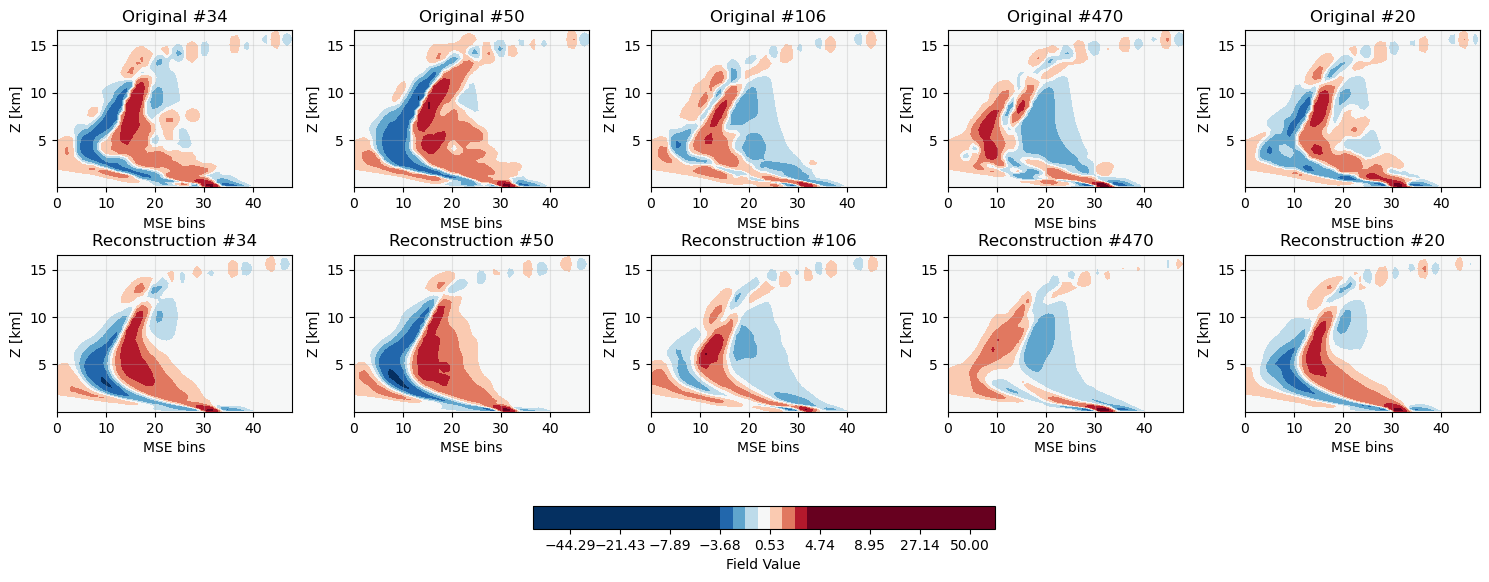

In [32]:
# ===============================================================
# Original vs Reconstructed Fields (VAE)
# ===============================================================
# Visualize a few samples from the validation dataset alongside
# their VAE reconstructions. All fields are flipped vertically,
# plotted on the (S, Z) grid, and share consistent contour levels.
# ===============================================================

# -----------------------------
# Sample indices
# -----------------------------
samples = [34, 50, 106, 470, 20]

# -----------------------------
# Reconstruction helper
# -----------------------------
def get_img(idx, arr):
    """Return vertically flipped 48×48 image for a given index."""
    img = create_image_from_flat_tensor(arr)[idx]
    return img#np.flipud(img)

# -----------------------------
# Contour limits + levels
# -----------------------------
vmin, vmax = -4, 4
levels = np.concatenate([
    np.linspace(-150, -50, 3),
    np.linspace(-50, -10, 8),
    np.linspace(-10, 10, 20),
    np.linspace(10, 50, 8),
    np.linspace(50, 150, 3)
])
levels = np.sort(np.unique(levels))

# -----------------------------
# Grid (48×48 window)
# -----------------------------
S_plot = S[:48, :48]
Z_plot = Z[:48, :48]

# -----------------------------
# Figure setup
# -----------------------------
fig, ax = plt.subplots(2, len(samples), figsize=(15, 6))

for i, idx in enumerate(samples):

    # Original & reconstruction
    orig_img = get_img(idx, val_original_imgs)
    recon_img = get_img(idx, val_reconstructed_imgs)

    # ------ Original ------
    im = ax[0, i].contourf(
        S_plot, Z_plot, orig_img,
        levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax
    )
    ax[0, i].set_title(f"Original #{idx}")
    ax[0, i].set_xlabel("MSE bins")
    ax[0, i].set_ylabel("Z [km]")
    ax[0, i].grid(True, alpha=0.3)

    # ------ Reconstruction ------
    ax[1, i].contourf(
        S_plot, Z_plot, recon_img,
        levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax
    )
    ax[1, i].set_title(f"Reconstruction #{idx}")
    ax[1, i].set_xlabel("MSE bins")
    ax[1, i].set_ylabel("Z [km]")
    ax[1, i].grid(True, alpha=0.3)

# -----------------------------
# Shared colorbar
# -----------------------------
cbar = fig.colorbar(
    im, ax=ax.ravel().tolist(),
    orientation='horizontal',
    fraction=0.05, pad=-0.32,
    label="Field Value"
)

plt.tight_layout()
plt.show()


/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_56934/1060791198.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


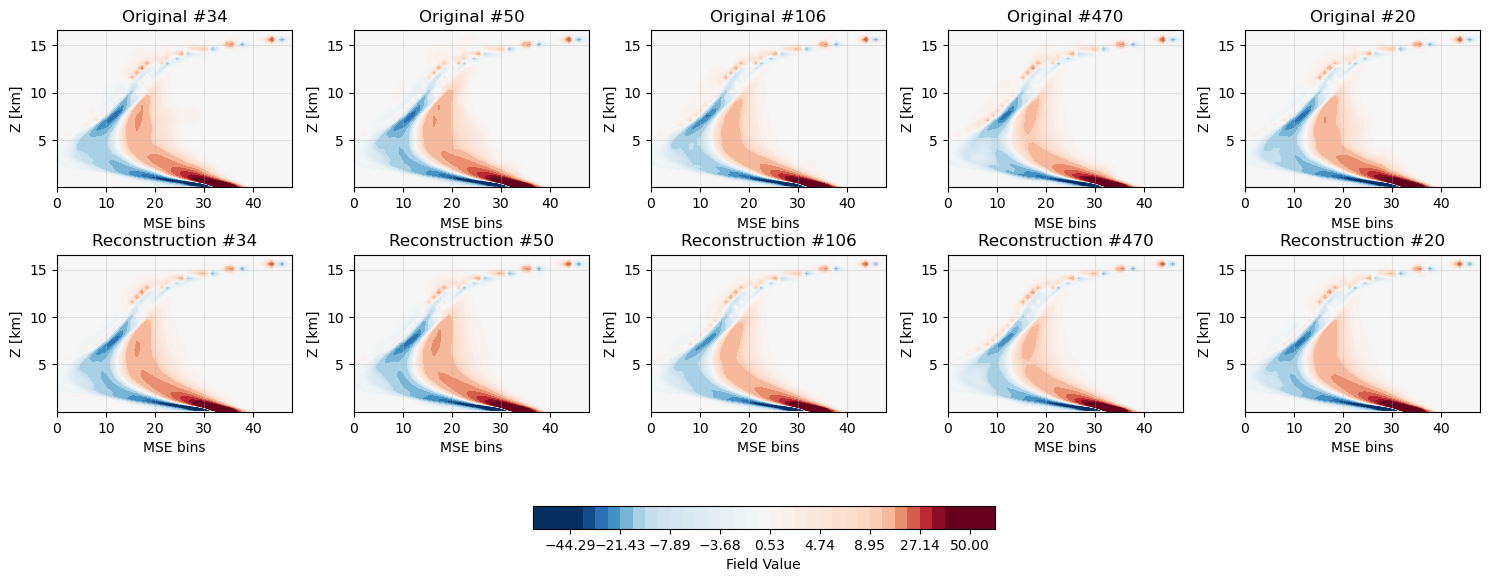

In [33]:
# ===============================================================
# Original vs Reconstructed Fields (VAE)
# ===============================================================
# Visualize a few samples from the validation dataset alongside
# their VAE reconstructions. All fields are flipped vertically,
# plotted on the (S, Z) grid, and share consistent contour levels.
# ===============================================================

# -----------------------------
# Sample indices
# -----------------------------
samples = [34, 50, 106, 470, 20]

# -----------------------------
# Reconstruction helper
# -----------------------------
def get_img(idx, arr):
    """Return vertically flipped 48×48 image for a given index."""
    img = create_image_from_flat_tensor(arr)[idx]
    return img+rho_w_mean #np.flipud(img)

# -----------------------------
# Contour limits + levels
# -----------------------------
vmin, vmax = -40, 40
levels = np.concatenate([
    np.linspace(-150, -50, 3),
    np.linspace(-50, -10, 8),
    np.linspace(-10, 10, 20),
    np.linspace(10, 50, 8),
    np.linspace(50, 150, 3)
])
levels = np.sort(np.unique(levels))

# -----------------------------
# Grid (48×48 window)
# -----------------------------
S_plot = S[:48, :48]
Z_plot = Z[:48, :48]

# -----------------------------
# Figure setup
# -----------------------------
fig, ax = plt.subplots(2, len(samples), figsize=(15, 6))

for i, idx in enumerate(samples):

    # Original & reconstruction
    orig_img = get_img(idx, val_original_imgs)
    recon_img = get_img(idx, val_reconstructed_imgs)

    # ------ Original ------
    im = ax[0, i].contourf(
        S_plot, Z_plot, orig_img,
        levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax
    )
    ax[0, i].set_title(f"Original #{idx}")
    ax[0, i].set_xlabel("MSE bins")
    ax[0, i].set_ylabel("Z [km]")
    ax[0, i].grid(True, alpha=0.3)

    # ------ Reconstruction ------
    ax[1, i].contourf(
        S_plot, Z_plot, recon_img,
        levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax
    )
    ax[1, i].set_title(f"Reconstruction #{idx}")
    ax[1, i].set_xlabel("MSE bins")
    ax[1, i].set_ylabel("Z [km]")
    ax[1, i].grid(True, alpha=0.3)

# -----------------------------
# Shared colorbar
# -----------------------------
cbar = fig.colorbar(
    im, ax=ax.ravel().tolist(),
    orientation='horizontal',
    fraction=0.05, pad=-0.32,
    label="Field Value"
)

plt.tight_layout()
plt.show()


## 3.  `PCA Structure of the Latent Space`

In [34]:
# ===============================================================
# Run VAE Inference on the Full Dataset
# ===============================================================
# This cell:
# 1. Passes all samples through the pretrained VAE
# 2. Stores latent means (μ), reconstructed fields, and originals
# 3. Concatenates everything into full arrays for later analysis
# ===============================================================

# Convert full dataset to tensor + dataloader
full_tensor = torch.tensor(data_input, dtype=torch.float32)
full_loader = DataLoader(full_tensor, batch_size=128, shuffle=False)

model.eval()  # inference mode

full_latent_reprs = []        # latent μ(t)
full_reconstructed_imgs = []  # reconstructed fields
full_original_imgs = []       # original inputs

# -----------------------------
# Inference loop
# -----------------------------
for batch in full_loader:
    
    # Save originals
    full_original_imgs.append(batch)

    # Move to device
    batch = batch.to(device)

    # Forward pass (no gradient)
    with torch.no_grad():
        recon, mu, _ = model(batch)

    # Store outputs
    full_latent_reprs.append(mu.cpu())
    full_reconstructed_imgs.append(recon.cpu())

# -----------------------------
# Concatenate all batches
# -----------------------------
full_latent_reprs      = np.concatenate(full_latent_reprs)
full_reconstructed_imgs = np.concatenate(full_reconstructed_imgs)
full_original_imgs      = np.concatenate(full_original_imgs)

full_original_imgs.shape, full_reconstructed_imgs.shape, full_latent_reprs.shape


((19476, 1560), (19476, 1560), (19476, 8))

In [14]:
# ===============================================================
# PCA Projection of Latent Space + Density Estimation
# ===============================================================
# This cell:
# 1. Projects the full latent space onto 2D using PCA
# 2. Computes a pointwise density via Gaussian KDE
# 3. Normalizes density for better visualization
# ===============================================================

# -----------------------------
# PCA reduction to 2 components
# -----------------------------
reducer = PCA(n_components=2)
latent_2d = reducer.fit_transform(full_latent_reprs)
method = "PCA"

# -----------------------------
# Density estimation in 2D
# -----------------------------
xy = np.vstack([latent_2d[:, 0], latent_2d[:, 1]])
density = gaussian_kde(xy)(xy)        # evaluate KDE at each point
density = density / density.max()     # normalize (optional, for plotting)


Principal Axis 1: 33.89% explained variance
Principal Axis 2: 17.79% explained variance


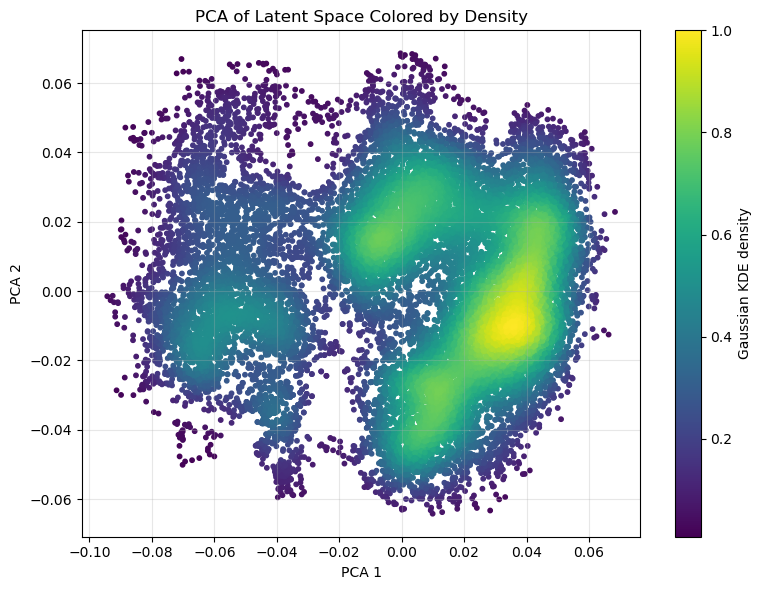

In [15]:
# ===============================================================
# PCA Explained Variance + Latent Space Visualization
# ===============================================================
# This cell:
# 1. Prints variance explained by each PCA axis
# 2. Plots the 2D PCA projection colored by KDE density
# ===============================================================

# -----------------------------
# Print PCA explained variance
# -----------------------------
explained_variances = reducer.explained_variance_ratio_
for i, var in enumerate(explained_variances):
    print(f"Principal Axis {i+1}: {var*100:.2f}% explained variance")

# -----------------------------
# Scatter plot of latent space
# -----------------------------
plt.figure(figsize=(8, 6))

sc = plt.scatter(
    latent_2d[:, 0], latent_2d[:, 1],
    c=density, cmap='viridis', s=10
)

plt.colorbar(sc, label='Gaussian KDE density')
plt.xlabel(f'{method} 1')
plt.ylabel(f'{method} 2')
plt.title(f'{method} of Latent Space Colored by Density')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


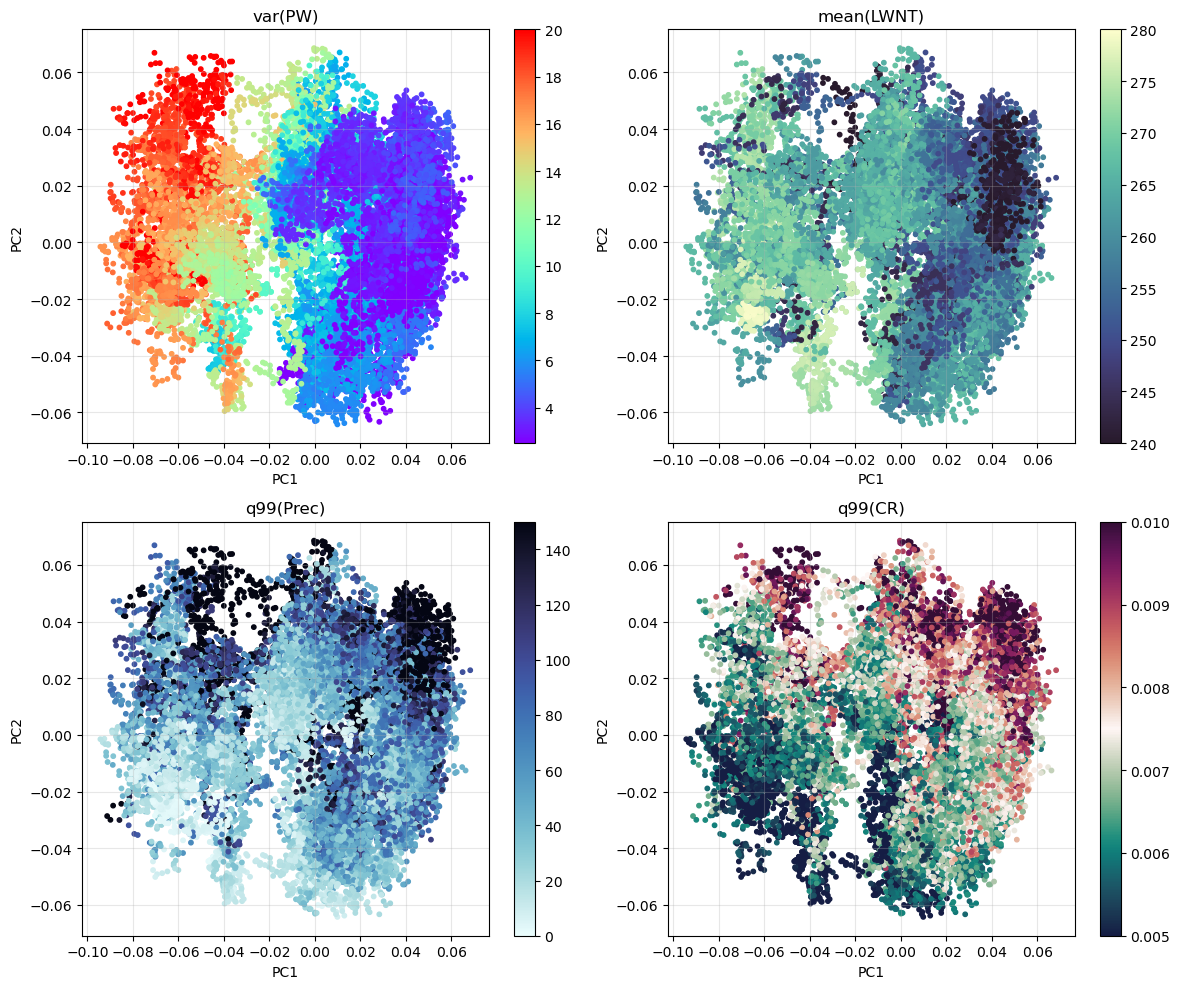

var(PW): vmin=2.5000, vmax=20.0000
mean(LWNT): vmin=240.0000, vmax=280.0000
q99(Prec): vmin=0.0000, vmax=150.0000
q99(CR): vmin=0.0050, vmax=0.0100


In [16]:
# ===============================================================
# Latent PCA Space Colored by Physical Indexes
# ===============================================================
# This cell loads several physical diagnostics (PW variance,
# outgoing LW radiation, extreme precipitation, and extreme
# condensation rate) and colors the 2D PCA latent space using
# each index. Each panel uses its own scientific colormap.
# ===============================================================

# -----------------------------
# Paths + titles for each index
# -----------------------------
paths = [
    os.path.join(DATA_FOLDER_PATH,'indexes/var_PW.npy'),
    os.path.join(DATA_FOLDER_PATH, 'indexes/mean_LWNT.npy'),
    os.path.join(DATA_FOLDER_PATH,'indexes/q99_Prec.npy'),
     os.path.join(DATA_FOLDER_PATH,'indexes/q99_CR.npy')
]

titles = ["var(PW)", "mean(LWNT)", "q99(Prec)", "q99(CR)"]

# -----------------------------
# Custom colormap for each panel
# -----------------------------
cmaps = ["rainbow", cmocean.cm.deep_r, cmocean.cm.ice_r, cmocean.cm.curl]

# -----------------------------
# Fixed vmin / vmax for clarity
# -----------------------------
vmins = [2.5, 240, 0, 0.005]
vmaxs = [20, 280, 150, 0.01]

# To store limits and print later
vmin_vmax = []

# -----------------------------
# Create figure
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.ravel()):
    
    # Load the index time series
    index_i = np.load(paths[i])
    
    # Set color range
    vmin = vmins[i]
    vmax = vmaxs[i]
    vmin_vmax.append((titles[i], vmin, vmax))
    
    # Scatter in latent PCA space
    sc = ax.scatter(
        latent_2d[:, 0],
        latent_2d[:, 1],
        c=index_i,
        cmap=cmaps[i],
        s=10,
        vmin=vmin,
        vmax=vmax
    )
    
    ax.set_title(titles[i])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)

    plt.colorbar(sc, ax=ax)

plt.tight_layout()
plt.show()

# -----------------------------
# Print chosen vmin/vmax ranges
# -----------------------------
for name, vmin, vmax in vmin_vmax:
    print(f"{name}: vmin={vmin:.4f}, vmax={vmax:.4f}")


## 4.  `Koopman Operator: Eigenvalues, Modes, and Reconstructions`

In [17]:
# ================================================================
# Prepare centered latent-space input/output pairs for Koopman fit
# ---------------------------------------------------------------
# - X_input  = z(t)
# - X_output = z(t+dt)
# - We also center both using the global latent-mean for stability
# ================================================================

# Construct input-output pairs
X_input  = full_latent_reprs[:-1]   # z(t)
X_output = full_latent_reprs[1:]    # z(t+dt)

# Compute mean latent state for centering
mean_latent = np.mean(full_latent_reprs, axis=0)

# Center the data (optional but recommended for Koopman regression)
X_input_centered  = X_input  - mean_latent
X_output_centered = X_output - mean_latent

# Display shapes for confirmation
X_input_centered.shape, X_output_centered.shape


((19475, 8), (19475, 8))

In [18]:
# ========================================================================
# Koopman Operator Estimation, Eigen-Decomposition, and Mode Reconstruction
# ========================================================================


# ---------------------------------------------------------------
# 1. Estimate Koopman operator K using centered latent trajectories
#    Solve Y ≈ K X  →  K = Y X⁺ (pseudo-inverse formulation)
# ---------------------------------------------------------------
X_pinv = np.linalg.pinv(X_input_centered)          # Moore–Penrose pseudo-inverse
K_op = X_output_centered.T @ X_input_centered @ np.linalg.inv(X_input_centered.T @ X_input_centered)

# ---------------------------------------------------------------
# 2. Koopman eigen-decomposition
# ---------------------------------------------------------------
eigvals, eigvecs = np.linalg.eig(K_op)

# Sort eigenvalues/eigenvectors by |λ|
idx = np.argsort(np.abs(eigvals))[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("Eigenvector norms:", np.linalg.norm(eigvecs, axis=0))

# ---------------------------------------------------------------
# 3. Explained-variance contribution of each Koopman mode
# ---------------------------------------------------------------
explained_variance = []

# Total energy of centered data (for normalization)
total_var = np.sum(np.linalg.norm(X_output_centered, axis=1)**2)
print("Total variance of latent data:", total_var)

sigma_i_list = []

for i in range(len(eigvals)):
    mode_i = eigvecs[:, i]
    
    # Projection of data onto Koopman mode
    projection = X_output_centered @ mode_i   # shape (N,)
    
    print(f"Mode {i}: mean={np.mean(projection):.4e}, std={np.std(projection):.4e}")
    sigma_i_list.append(np.std(projection))

    # Mode "power" = sum of squared projected amplitudes
    mode_power = np.sum(np.abs(projection)**2)
    explained_variance.append(mode_power / total_var)

explained_variance = np.array(explained_variance)

# ---------------------------------------------------------------
# 4. Reconstruct Koopman modal dynamics (real + imaginary parts)
# ---------------------------------------------------------------
num_modes_to_plot = 8
timesteps = 500
modes = []

# Estimate typical scale of latent space for normalization
latent_scale = np.mean(np.abs(X_output_centered))

for i in range(num_modes_to_plot):
    v0 = eigvecs[:, i]
    lam = eigvals[i]

    # Normalize eigenvector magnitude for nicer trajectories
    koopman_scale = np.mean(np.abs(v0))
    v0_scaled = v0 * (latent_scale / koopman_scale)

    # Time evolution:  v(t) = λ^t * v₀
    v_t_complex = np.array([(lam**t) * v0_scaled for t in range(timesteps)])

    # Store real and imaginary components separately
    modes.append(np.real(v_t_complex))
    modes.append(np.imag(v_t_complex))

    print(f"Mode {i+1}: λ = {lam:.4f}, explained variance = {explained_variance[i]*100:.2f}%")


Eigenvector norms: [1.         1.         1.         1.         1.         0.99999994
 1.         1.        ]
Total variance of latent data: 78.80222
Mode 0: mean=2.1382e-06+0.0000e+00j, std=3.5888e-02
Mode 1: mean=1.3065e-06+0.0000e+00j, std=2.6631e-02
Mode 2: mean=1.3702e-06+0.0000e+00j, std=2.5184e-02
Mode 3: mean=1.5335e-06-2.2854e-07j, std=2.3618e-02
Mode 4: mean=1.5335e-06+2.2854e-07j, std=2.3618e-02
Mode 5: mean=2.0342e-06+0.0000e+00j, std=2.1360e-02
Mode 6: mean=8.9043e-07+3.4187e-07j, std=1.4089e-02
Mode 7: mean=8.9043e-07-3.4187e-07j, std=1.4089e-02
Mode 1: λ = 0.9977+0.0000j, explained variance = 31.83%
Mode 2: λ = 0.9968+0.0000j, explained variance = 17.53%
Mode 3: λ = 0.9946+0.0000j, explained variance = 15.67%
Mode 4: λ = 0.9874-0.0168j, explained variance = 13.79%
Mode 5: λ = 0.9874+0.0168j, explained variance = 13.79%
Mode 6: λ = 0.9835+0.0000j, explained variance = 11.28%
Mode 7: λ = 0.9642-0.0735j, explained variance = 4.91%
Mode 8: λ = 0.9642+0.0735j, explained varia

In [19]:
# =======================================================
# Construct Koopman Mode Trajectory for a Selected Mode i
# =======================================================

i = 3  # Mode index to visualize

# -------------------------------------------------------
# Scale eigenvector using twice the mode's projection std
# → produces a representative amplitude for visualization
# -------------------------------------------------------
Phi_i = eigvecs[:, i] * 2 * sigma_i_list[i]

# -------------------------------------------------------
# Normalize eigenvalue to remove damping/growth
# → keeps only pure oscillation: λ_norm = λ / |λ|
# -------------------------------------------------------
lambda_i = eigvals[i] / np.abs(eigvals[i])

# -------------------------------------------------------
# Build 500-step trajectory:
#     z(t) = λ_norm^t · Φ_i
# Real and imaginary parts can be interpreted as
# oscillator coordinates.
# -------------------------------------------------------
trajectory = np.array([
    (lambda_i ** t) * Phi_i
    for t in range(500)
])


In [20]:
# ================================================================
# Animate Koopman Mode in Physical Space Using VAE Decoder
# ================================================================
# This cell:
#   • Selects a Koopman mode i
#   • Normalizes its eigenvalue to extract pure oscillation
#   • Constructs the time-evolving latent state z(t)
#   • Decodes real and imaginary trajectories back into 48×48 fields
#   • Stores them for later animation
# ================================================================

# -----------------------------
# Mode selection and parameters
# -----------------------------
i = 3                      # mode index to animate
eigval = eigvals[i]        # complex eigenvalue
eigvec = eigvecs[:, i] * 2 * sigma_i_list[i]  # scaled Koopman mode
T = 600                    # number of animation frames

# -----------------------------
# Latent-space mean (for centering)
# -----------------------------
device = next(model.parameters()).device
mean_latent_tensor = torch.tensor(mean_latent, dtype=torch.float32, device=device)

# -----------------------------
# Storage for decoded frames
# -----------------------------
decoded_real = []
decoded_imag = []

# ================================================================
# Generate real and imaginary trajectories in latent space,
# decode them into physical fields through the VAE decoder
# ================================================================
with torch.no_grad():
    for t in range(T):

        # Pure oscillation (remove amplitude growth/decay)
        factor = (eigval / np.abs(eigval)) ** t

        # Time-evolving latent vector: z(t) = λ_norm^t · Φ_i
        z_t = eigvec * factor

        # Real and imaginary “oscillator coordinates”
        real_input = torch.tensor(
            np.real(z_t) + mean_latent,
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        imag_input = torch.tensor(
            np.imag(z_t) + mean_latent,
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        # Decode into physical space
        real_out = model.decoder(real_input).cpu()
        imag_out = model.decoder(imag_input).cpu()

        # Undo signed-log transform used for training
        decoded_real.append(inv_log_signed(real_out))
        decoded_imag.append(inv_log_signed(imag_out))

# -----------------------------
# Convert decoded tensors to 48×48 arrays
# -----------------------------
frames_real = [create_image_from_flat_tensor(fr)[0] for fr in decoded_real]
frames_imag = [create_image_from_flat_tensor(fr)[0] for fr in decoded_imag]


/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_56934/2057916365.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sign(x) * (np.exp(np.abs(x)) - 1)


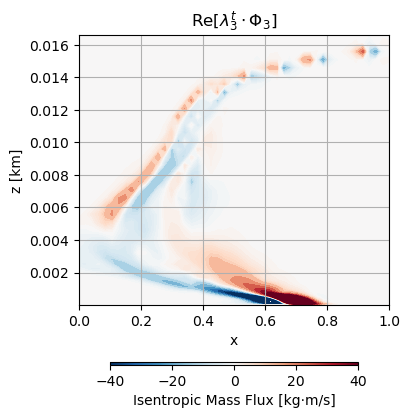

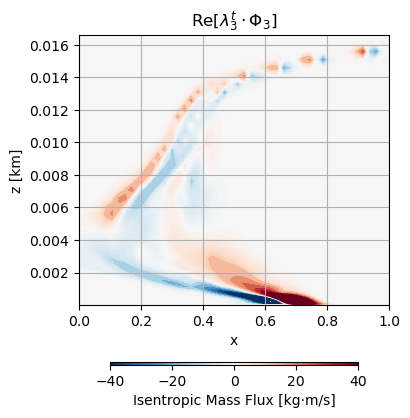

In [21]:
# ================================================================
# Visualize Real Part of Koopman Mode Dynamics in Physical Space
# ================================================================
# This cell:
#   • Builds x–z physical grid
#   • Uses contourf with smooth diverging levels
#   • Adds grid, labels, horizontal colorbar
#   • Loops over animation frames (or test frames)
# ================================================================

# -----------------------------
# Build physical coordinate grid
# -----------------------------
z = z_array[:48] / 1000           # height in km
x = np.linspace(0, 1, 48)         # horizontal coordinate (unitless)
XX, ZZ = np.meshgrid(x, z)        # shape (48, 48)

# -----------------------------
# Colormap limits + contour levels
# -----------------------------
vmin, vmax = -40, 40
levels = np.concatenate([
    np.linspace(-150, -50, 3),
    np.linspace(-50, -10, 8),
    np.linspace(-10, 10, 20),
    np.linspace(10, 50, 8),
    np.linspace(50, 150, 3)
])
levels = np.sort(np.unique(levels))

# -----------------------------
# Loop over frames
# -----------------------------
# for t in tqdm(range(350)):
for t in range(2):   # small test preview
    fig, ax = plt.subplots(figsize=(4, 5))

    # Field = decoded real part + climatological mean
    field = frames_real[t] + rho_w_mean

    # Contour plot
    c = ax.contourf(
        XX, ZZ, field,
        cmap='RdBu_r',
        levels=levels,
        vmin=vmin,
        vmax=vmax
    )

    # Labels + formatting
    ax.set_title(r"Re[$\lambda_3^t \cdot \Phi_3$]")
    ax.set_xlabel("x")
    ax.set_ylabel("z [km]")
    ax.grid(True)

    # -------------------------
    # Horizontal colorbar
    # -------------------------
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap='RdBu_r')

    fig.colorbar(
        sm, ax=ax,
        shrink=0.8,
        orientation='horizontal',
        aspect=110,
        label="Isentropic Mass Flux [kg·m/s]"
    )

    #plt.tight_layout()
    # plt.savefig(f"mode_vizu_2/fig_{str(t).zfill(4)}.png")
    # plt.close()


## 5.  `Modal Projections, Spectral Analysis, and Latent-Space Velocities`

In [22]:
# ================================================================
# Project Full Latent Trajectory onto Leading Koopman Modes
# ================================================================
# This cell computes the temporal coefficients a_i(t) = <Z(t), φ_i>
# for the first n_modes Koopman eigenvectors.
#   • Scales each Koopman mode using its empirical std (σ_i)
#   • Computes inner products with the full latent trajectory
#   • Uses only the REAL part → consistent with physical interpretation
# Output: projections[i, t] = projection of mode i at time t
# ================================================================

n_modes = 8
T = full_latent_reprs.shape[0]

projections = []   # list → will become array of shape (n_modes, T)

for i in range(n_modes):

    # ------------------------------------------------------------
    # Construct scaled Koopman mode φ_i
    # ------------------------------------------------------------
    Phi_i = eigvecs[:, i] * 2 * sigma_i_list[i]

    # ------------------------------------------------------------
    # Compute temporal projection: a_i(t) = <Z(t), φ_i>
    # ------------------------------------------------------------
    proj = full_latent_reprs @ Phi_i     # shape (T,)

    # Keep real part only (mode amplitudes should be real)
    proj = np.real(proj)

    projections.append(proj)

# Convert to array for convenience
projections = np.array(projections)   # final shape → (n_modes, T)


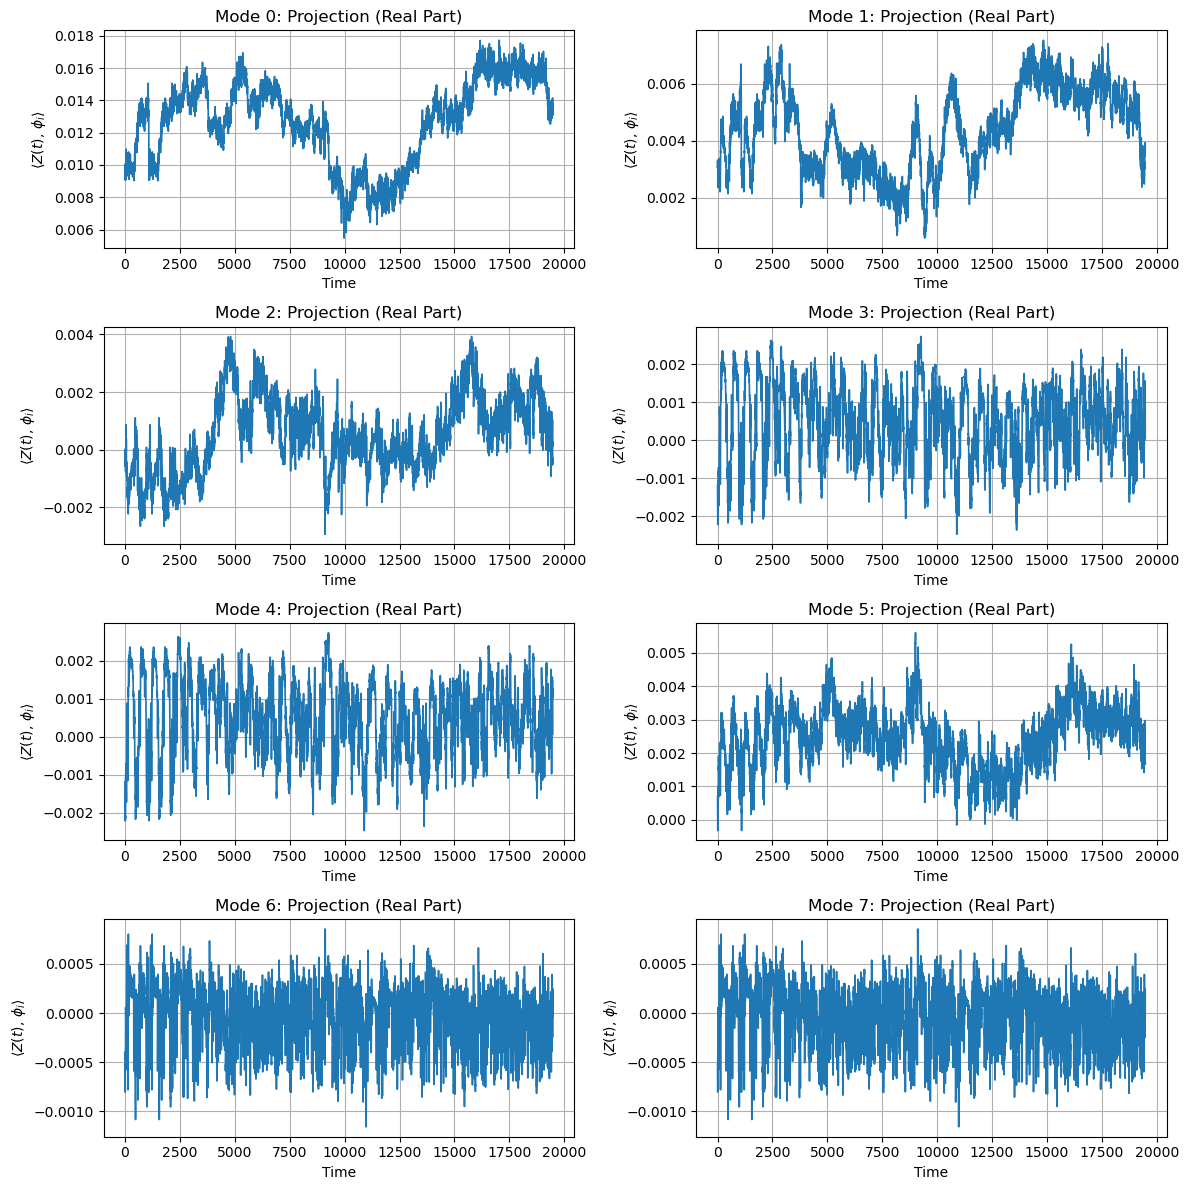

In [23]:
# ================================================================
# Plot Temporal Projections onto Koopman Modes
# ================================================================
# This cell visualizes the time evolution of the modal coefficients
#    a_i(t) = <Z(t), φ_i>
# for the first n_modes eigenvectors. Each subplot shows how strongly
# the full latent trajectory aligns with a given Koopman mode.
# ================================================================

fig, axes = plt.subplots(4, 2, figsize=(12, 12))   # 8 modes → 4×2 grid
axes = axes.ravel()

for i in range(n_modes):
    ax = axes[i]

    # Plot a_i(t)
    ax.plot(projections[i], lw=1.2)

    ax.set_title(f"Mode {i}: Projection (Real Part)")
    ax.set_xlabel("Time")
    ax.set_ylabel(r"$\langle Z(t),\, \phi_i \rangle$")
    ax.grid(True)

plt.tight_layout()
plt.show()


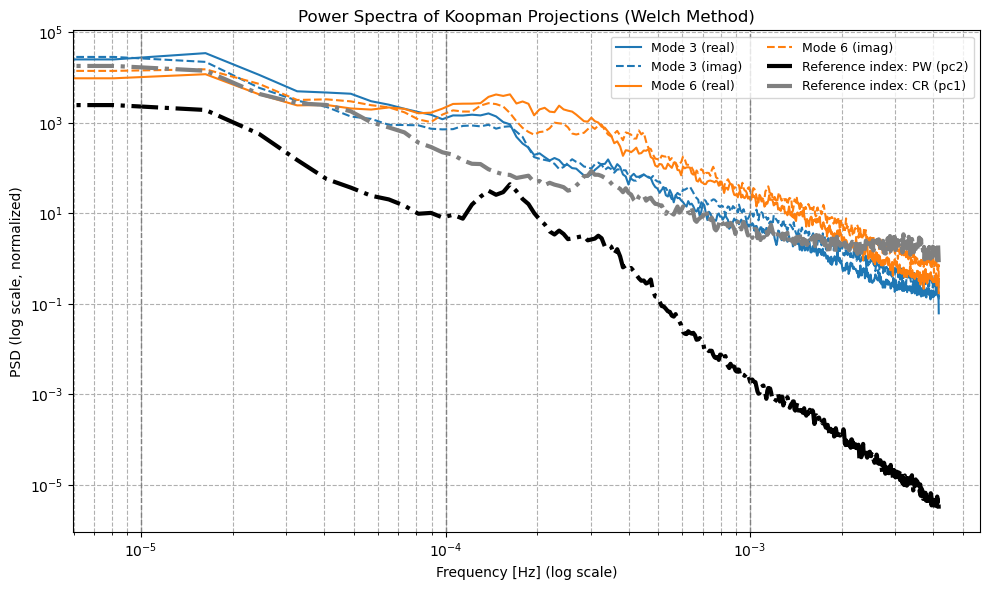

In [24]:
# ================================================================
# Power Spectral Density of Koopman Projections
# ================================================================
# This cell computes the PSD (Welch method) of selected Koopman
# mode projections a_i(t) = <Z(t), φ_i>, and compares them to
# physical reference indices (PW, CR).
#
# For each selected mode:
#   – real part shown with solid line
#   – imaginary part (if meaningful) shown with dashed line
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# ------------------------------------------------
# Load reference climate / physical indices
# ------------------------------------------------
pc2 = np.load(os.path.join(DATA_FOLDER_PATH,'indexes/var_PW.npy'))
pc1 = np.load(os.path.join(DATA_FOLDER_PATH, 'indexes/q95_CR.npy'))

# ------------------------------------------------
# Sampling parameters
# ------------------------------------------------
dt = 120.0           # sampling interval [s]
fs = 1.0 / dt        # sampling frequency [Hz]

plt.figure(figsize=(10, 6))

imag_threshold = 1e-8   # imaginary part must exceed this std to be plotted

# ------------------------------------------------
# Color map for selected Koopman modes
# ------------------------------------------------
mode_list = [3, 6]
cmap = plt.get_cmap("tab10")
mode_colors = {m: cmap(i) for i, m in enumerate(mode_list)}

# ================================================================
# Koopman Mode PSD
# ================================================================
for mode_index in mode_list:

    # Koopman mode φ_i, scaled properly
    Phi_i = eigvecs[:, mode_index] * 2 * sigma_i_list[mode_index]

    # Projection a_i(t) = <Z(t), φ_i>
    proj = full_latent_reprs @ Phi_i   # shape (T,)

    # ----- Real part -----
    real_part = proj.real
    real_norm = (real_part - np.mean(real_part)) / np.std(real_part)

    f_real, pxx_real = welch(
        real_norm, fs=fs, nperseg=1024, scaling='density'
    )
    plt.loglog(
        f_real, pxx_real,
        linestyle='-',
        color=mode_colors[mode_index],
        label=f"Mode {mode_index} (real)"
    )

    # ----- Imaginary part (if significant) -----
    imag_part = proj.imag
    if np.std(imag_part) > imag_threshold:
        imag_norm = (imag_part - np.mean(imag_part)) / np.std(imag_part)

        f_imag, pxx_imag = welch(
            imag_norm, fs=fs, nperseg=1024, scaling='density'
        )
        plt.loglog(
            f_imag, pxx_imag,
            linestyle='--',
            color=mode_colors[mode_index],
            label=f"Mode {mode_index} (imag)"
        )

# ================================================================
# Physical Reference Signals
# ================================================================

# -- PW variance index --
pw_norm = (pc2 - np.mean(pc2)) / np.std(pc2)
f_pw, pxx_pw = welch(pw_norm, fs=fs, nperseg=1024, scaling='density')
plt.loglog(
    f_pw, pxx_pw,
    linestyle='-.', linewidth=3,
    color='k', label="Reference index: PW (pc2)"
)

# -- CR 95th percentile index --
cr_norm = (pc1 - np.mean(pc1)) / np.std(pc1)
f_cr, pxx_cr = welch(cr_norm, fs=fs, nperseg=1024, scaling='density')
plt.loglog(
    f_cr, pxx_cr,
    linestyle='-.', linewidth=3,
    color='gray', label="Reference index: CR (pc1)"
)

# ================================================================
# Highlight frequencies of interest
# ================================================================
highlight_freqs = [1e-5, 1e-4, 1e-3]
for f in highlight_freqs:
    plt.axvline(f, color='gray', linestyle='--', linewidth=1)

# ================================================================
# Formatting
# ================================================================
plt.xlabel("Frequency [Hz] (log scale)")
plt.ylabel("PSD (log scale, normalized)")
plt.title("Power Spectra of Koopman Projections (Welch Method)")
plt.grid(True, which="both", ls="--")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


In [25]:
# -----------------------------------------
# Empirical velocity v_emp(t)
# -----------------------------------------
delta_t = 2          # hours
dt = 2/60            # 2 minutes in hours
nstep = int(delta_t / dt)   # number of steps corresponding to 2 hours
print("nstep =", nstep)

# empirical velocity: shape (T - nstep, latent_dim)
v_t = (full_latent_reprs[nstep:] - full_latent_reprs[:-nstep]) / nstep


# -----------------------------------------
# Koopman-predicted velocities
# -----------------------------------------
complex_mode_index = [3, 4, 6, 7]

lamda = np.copy(eigvals)

# Normalize modulus to 1 for oscillatory modes (pure rotation)
lamda[complex_mode_index] = lamda[complex_mode_index] / np.abs(lamda[complex_mode_index])

# Power for Δt = nstep
lambda_norm_pow = lamda**nstep                  # shape (K,)

# Koopman velocity formula:
#   v_k(t) = (λ^Δt - 1)/Δt * <z(t), φ>
#
# projections has shape (K, T)
#
# Keep time range that matches v_t (T - nstep)
proj_t = projections[:, :-nstep]                # shape (K, T-nstep)


# -----------------------------------------
# All modes
# -----------------------------------------
v_koop_all_modes = ((lambda_norm_pow - 1)[:, None] * proj_t) / nstep
# shape (K, T - nstep)


# -----------------------------------------
# Oscillatory modes only
# -----------------------------------------
lambda_norm_pow_osc = lambda_norm_pow[complex_mode_index]
proj_t_osc = proj_t[complex_mode_index]

v_koop_only_oscill = (
    (lambda_norm_pow_osc - 1)[:, None] * proj_t_osc
) / nstep
# shape (#oscillatory modes, T - nstep)


nstep = 60
